# Traits and Plant Growth Rates

We have two datasets: 1) basal area each year from 2006 to 2011 and 2) plant and environmental traits for each tree. Below, I aim to examine the data - assess data types, check for missingness, normality, outliers. Depending on the degree of missingness, I will impute the data as we would like to keep as many observations as possible.

## Table of Contents
* Initial Assessment
* Imputation
* Estimate Growth Rate
* Conclusion

## Initial Assessment

I will assess the data classes (at each column),  missingness, whether the data are normal and the shape.

In [1]:
RGR.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/RGR.csv"))
MSH.Raw <- data.frame(read.csv("C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/MSH all data_July2015.csv"))

In [2]:
data_classes <- function(df){
    # given a dataframe, df, print the class of each column #
    df_class <- sapply(1:ncol(df), function (x) class(df[,x]))
    df_class <- data.frame(Variable = colnames(df), Class = df_class)
    cat("Class of each column\n\n")
    print(df_class)                  
}

In [3]:
data_classes(RGR.Raw)

Class of each column

   Variable   Class
1  SampleID  factor
2 BA.0.2006 numeric
3 BA.0.2007 numeric
4 BA.0.2008 numeric
5 BA.0.2009 numeric
6 BA.0.2010 numeric
7 BA.0.2011 numeric


Good, the only data being read as factors are the sampleIDs.

In [4]:
data_classes(MSH.Raw)

Class of each column

                  Variable   Class
1                 SampleID  factor
2         Height.DBH.Ratio numeric
3                    Estem numeric
4                    Etwig numeric
5       Branching.Distance numeric
6            Twig.Diameter numeric
7        Twig.Wood.Density numeric
8        Stem.Wood.Density numeric
9       Leaf.Mass.Fraction numeric
10               Leaf.Area numeric
11                     LMA numeric
12                     LCC numeric
13                     LNC numeric
14                     LPC numeric
15                    d15N numeric
16                    t.b2 numeric
17                      Ks numeric
18                   Ktwig numeric
19             Huber.Value numeric
20                   X.Lum numeric
21                      VD numeric
22               X.Sapwood numeric
23                    d13C numeric
24                Biomass5 numeric
25          pcent.max.Bio5 numeric
26   Symmetric.Competition numeric
27  Asymmetric.Competition numeri

Most of the trait data are numeric. The exceptions are site ID, sample ID, and species. 

In [5]:
data_missingness <- function(df){
    # given a dataframe, df, find the % and count of missing values (coded as NAs)
    # print the result
    data_missing_percentage <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))/nrow(df)*100})
    data_missing_count <- sapply(1:ncol(df), function (x){
        sum(is.na(df[,x]))})
    data_missing <- data.frame(Variable = colnames(df), Missing_Percent = data_missing_percentage,
                              Missing_Total = data_missing_count)
    cat("Percentage of observations missing from column\n\n")
    print(data_missing)
    cat("Mean % missing:", mean(data_missing[,2]),
       "\nTotal missing:", sum(data_missing[,3]))} 

In [6]:
data_missingness(RGR.Raw)

Percentage of observations missing from column

   Variable Missing_Percent Missing_Total
1  SampleID        0.000000             0
2 BA.0.2006        2.278481             9
3 BA.0.2007        2.531646            10
4 BA.0.2008        2.531646            10
5 BA.0.2009        2.531646            10
6 BA.0.2010        2.531646            10
7 BA.0.2011        2.278481             9
Mean % missing: 2.097649 
Total missing: 58

Only a small portion of the data are missing. But, most of the missingness is from 2007 to 2010. I need (atleast) 2006 and 2007 to measure growth rates. Maybe, imputations are an option. I will need to compare fit and see if that works. If not, we will just need to remove these rows. 

In [7]:
data_missingness(MSH.Raw)

Percentage of observations missing from column

                  Variable Missing_Percent Missing_Total
1                 SampleID        0.000000             0
2         Height.DBH.Ratio        0.000000             0
3                    Estem        0.000000             0
4                    Etwig        0.000000             0
5       Branching.Distance        0.000000             0
6            Twig.Diameter        0.000000             0
7        Twig.Wood.Density        0.000000             0
8        Stem.Wood.Density        0.000000             0
9       Leaf.Mass.Fraction        0.000000             0
10               Leaf.Area        0.000000             0
11                     LMA        0.000000             0
12                     LCC        0.000000             0
13                     LNC        0.000000             0
14                     LPC        0.000000             0
15                    d15N        0.000000             0
16                    t.b2        1.7721

A larger chunk of missingness from this dataframe. I will probably exclude columns with missingness greater than 50%. They are not worth trying to impute.

Since the data are non-normal, I will use predictive mean matching to impute the data (method = "ppm" in the mice package). I will also try robust EMbased imputation method in the VIM package (irmi).

In [8]:
library(e1071)

data_normality <- function(df){
    # given a dataframe, df, find the skewness and kurtosis and test for normality
    # but only include numeric columns
    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    data_skewness <- sapply(col_list, function (x){
        skewness(df[,x], na.rm = TRUE)})
    data_kurtosis <- sapply(col_list, function (x){
        kurtosis(df[,x], na.rm = TRUE)})
    data_normality <- sapply(col_list, function (x){
        shapiro.test(df[,x])})[1:2,]
    data_shape <- data.frame(Skewness = data_skewness,
                              Kurtosis = data_kurtosis, Shapiro_Test_W = as.numeric(unname(data_normality[1,])),
                            Shapiro_Test_pvalue = as.numeric(unname(data_normality[2,])))
    cat("Kurtosis, skewness & test for normality for each numeric column\n\n")
    print(data_shape)} 

Warning message:
"package 'e1071' was built under R version 3.6.3"

In [9]:
data_normality(RGR.Raw)

Kurtosis, skewness & test for normality for each numeric column

          Skewness Kurtosis Shapiro_Test_W Shapiro_Test_pvalue
BA.0.2006 2.205066 9.575192      0.8302604        6.727060e-20
BA.0.2007 1.974834 7.857950      0.8529547        1.531183e-18
BA.0.2008 1.732066 6.132620      0.8758313        4.888132e-17
BA.0.2009 1.523144 4.706086      0.8950752        1.313185e-15
BA.0.2010 1.401437 3.873564      0.9068659        1.226322e-14
BA.0.2011 1.273092 2.774428      0.9164002        8.264971e-14


Data are skewed and non-normal. 

In [10]:
data_normality(MSH.Raw)

Kurtosis, skewness & test for normality for each numeric column

                           Skewness    Kurtosis Shapiro_Test_W
Height.DBH.Ratio         0.61513858  0.36014192      0.9756856
Estem                    1.93601520  5.09889246      0.8265319
Etwig                    0.97278329  1.03804501      0.9434106
Branching.Distance       2.16421081  4.43289855      0.7139592
Twig.Diameter            1.99468523  5.70416006      0.8378735
Twig.Wood.Density       -0.40711246 -0.10137377      0.9851752
Stem.Wood.Density       -0.06266277 -0.81071742      0.9816907
Leaf.Mass.Fraction       0.87366639  0.42557354      0.9446927
Leaf.Area                2.79970650  8.41053692      0.6228780
LMA                      0.97713603  0.17666176      0.9035701
LCC                     -0.26548002 -0.19990420      0.9848028
LNC                      0.25376965 -0.11819716      0.9931637
LPC                      1.38658799  3.53654122      0.9167004
d15N                     0.99975400  4.53980921      

Some the data are skewed and non-normal.

In [11]:
library(tidyr) 
library(ggplot2)
library(hrbrthemes)
library(extrafont)
library(vegan)
library(gridExtra)
library(randomcoloR)

data_distribution <- function(df){
    # given a dataframe, df, plot a density histogram and density plot
    # the number of plots can differ between plots, so this function will vary the number of
    # plots within a grid arrange object

    col_list <- colnames(df)[which(sapply(1:ncol(df), function (x){is.numeric(df[,x])}))]
    colour_list <- distinctColorPalette(k = length(col_list))
    df_numeric <- df[, col_list]
    df_long <- gather(df_numeric , key = "group", value = "value")
    df_hist_density <- list()
    for (i in 1:length(col_list)){
        df_hist_density[[i]] <- 
            ggplot(subset(df_long,group == col_list[i]), aes(x = value)) +
            geom_histogram(aes(y = ..count.. / max(..count..)), color = colour_list[i], fill = colour_list[i],
                           position = "identity", alpha = 0.5, bins = 50)+
            geom_density(aes(y = ..scaled..), color = colour_list[i], alpha = 0.25)+
            labs( x = col_list[i], y = " ")+
            theme_bw() +
            theme(legend.position = "none")}
    if (length(col_list)<7){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density, ncol = 2)))}
    else if(length(col_list)<13){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:6)], ncol = 2)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(7:length(df_hist_density))], ncol = 2)))
        }
    else if(length(col_list)<19){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:9)], ncol = 3)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(10:length(df_hist_density))], ncol = 3)))
        }
    else if(length(col_list)<25){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(12:length(df_hist_density))], ncol = 4)))}
     else if(length(col_list)<37){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<49){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<61){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:48)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(49:length(df_hist_density))], ncol = 4)))}
    else if(length(col_list)<73){
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(1:12)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(13:24)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(25:36)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(37:48)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(49:60)], ncol = 4)))
        print(suppressWarnings(grid.arrange(grobs = df_hist_density[c(61:length(df_hist_density))], ncol = 4)))}
}

Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'hrbrthemes' was built under R version 3.6.3"Warning message:
"package 'extrafont' was built under R version 3.6.2"Registering fonts with R
Warning message:
"package 'vegan' was built under R version 3.6.3"Loading required package: permute
Warning message:
"package 'permute' was built under R version 3.6.3"Loading required package: lattice
This is vegan 2.5-6
Warning message:
"package 'gridExtra' was built under R version 3.6.3"Warning message:
"package 'randomcoloR' was built under R version 3.6.3"

TableGrob (3 x 2) "arrange": 6 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]
4 4 (2-2,2-2) arrange gtable[layout]
5 5 (3-3,1-1) arrange gtable[layout]
6 6 (3-3,2-2) arrange gtable[layout]


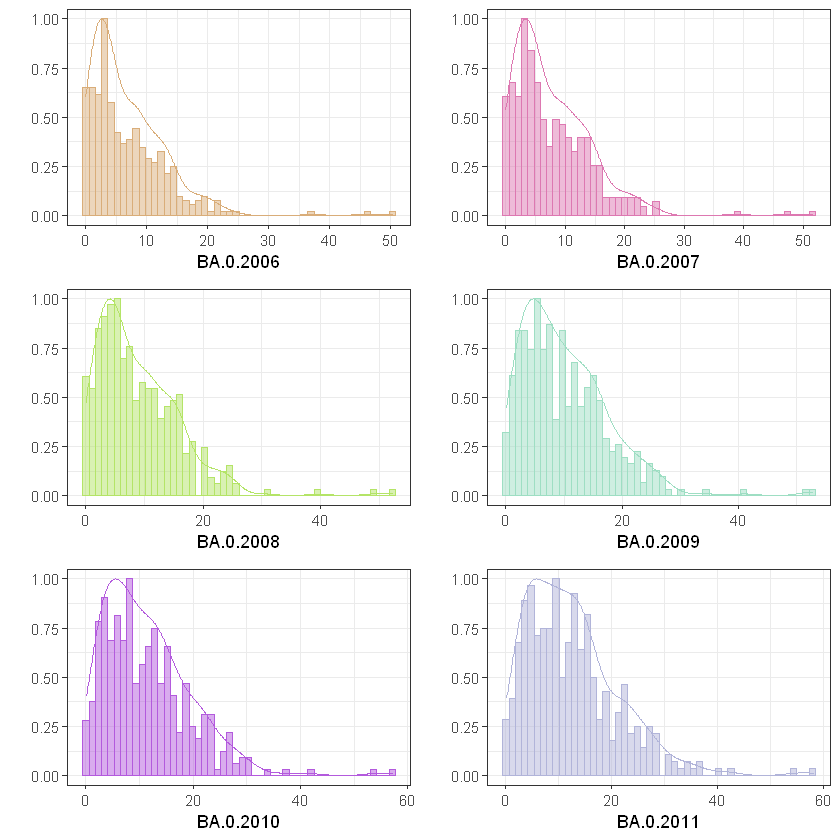

In [12]:
data_distribution(RGR.Raw)

Same as above, skewed data and visual evidence of kurtosis. 

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


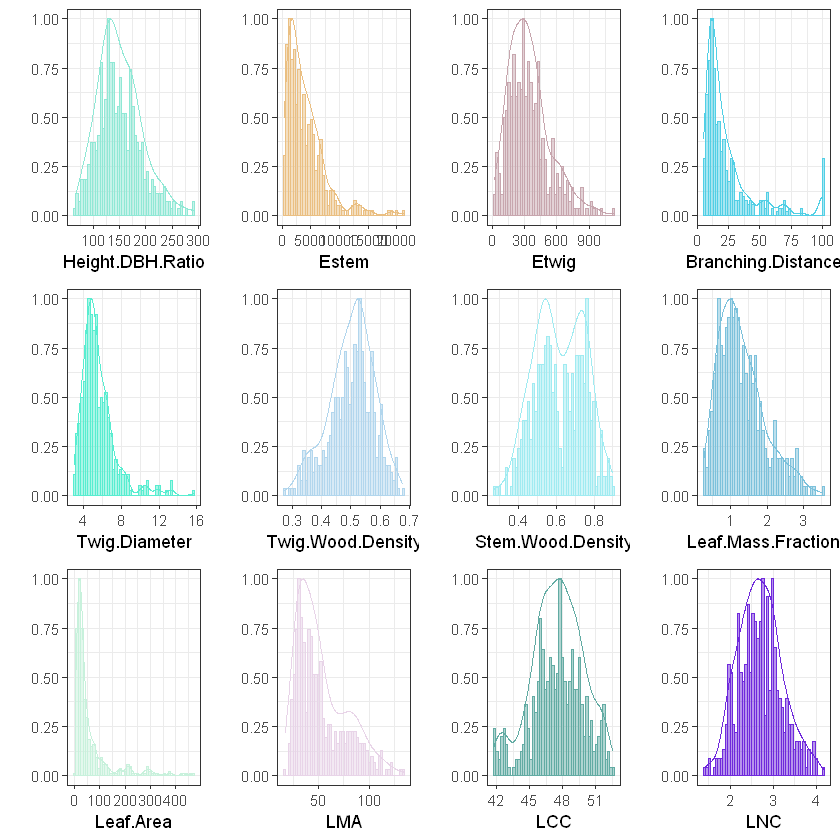

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


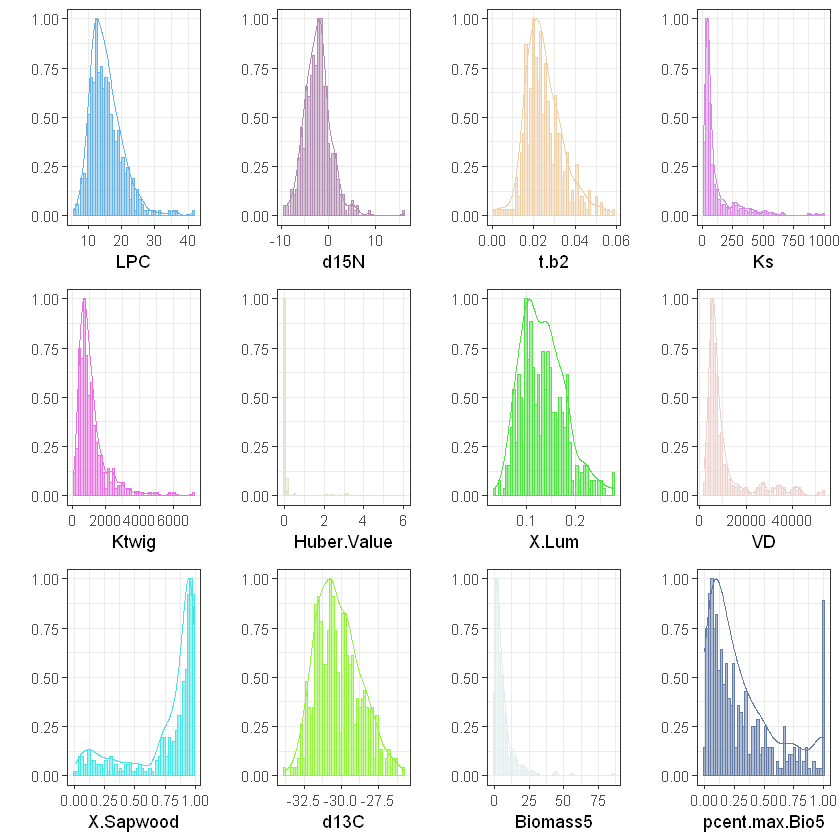

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


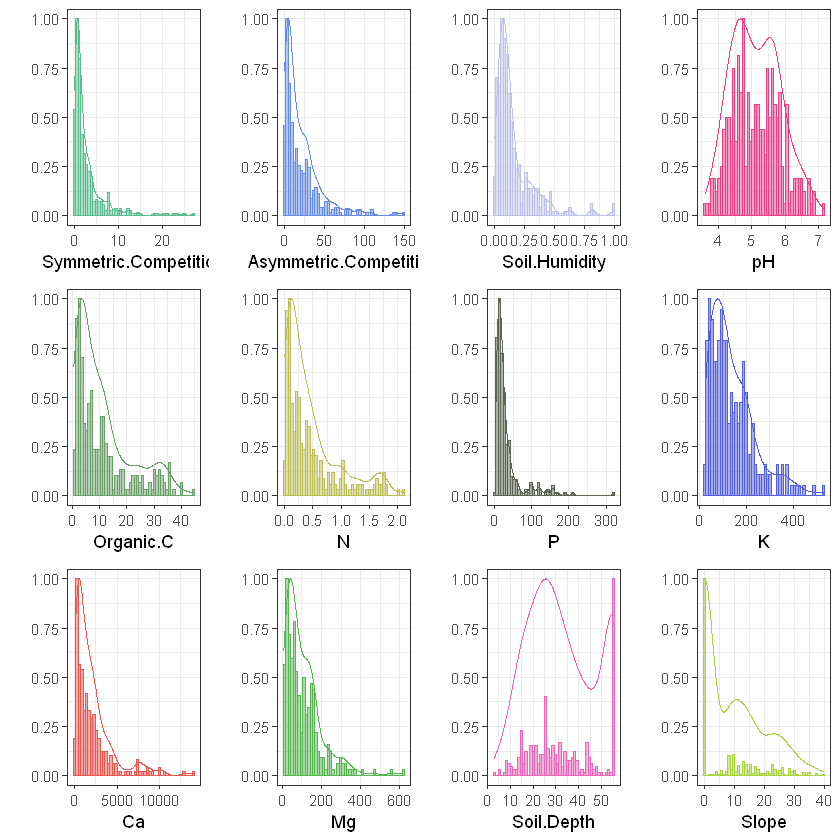

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


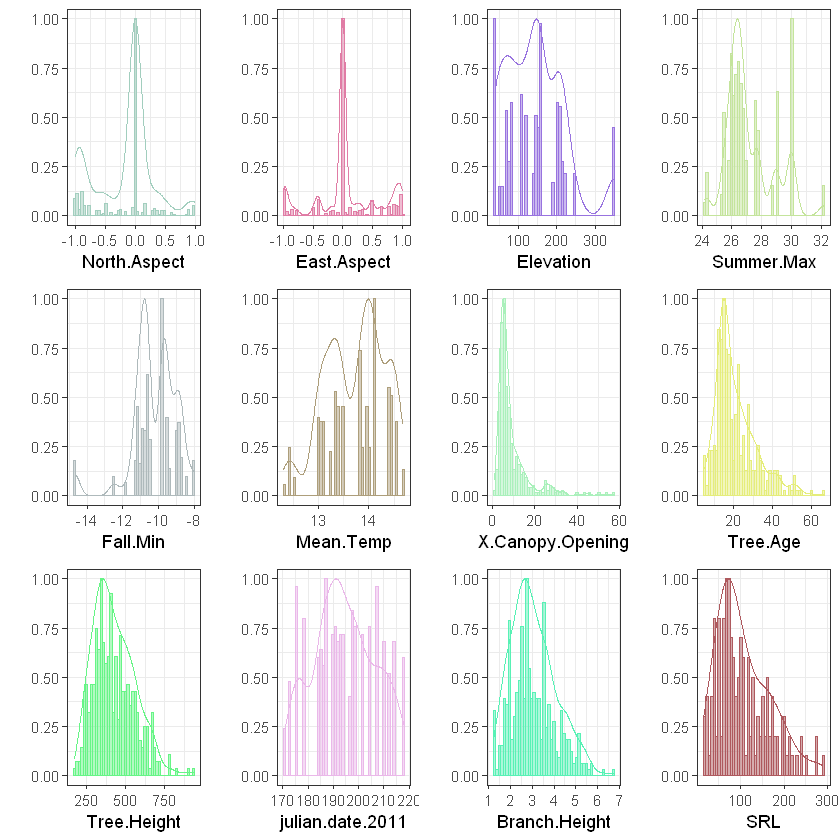

TableGrob (3 x 4) "arrange": 12 grobs
    z     cells    name           grob
1   1 (1-1,1-1) arrange gtable[layout]
2   2 (1-1,2-2) arrange gtable[layout]
3   3 (1-1,3-3) arrange gtable[layout]
4   4 (1-1,4-4) arrange gtable[layout]
5   5 (2-2,1-1) arrange gtable[layout]
6   6 (2-2,2-2) arrange gtable[layout]
7   7 (2-2,3-3) arrange gtable[layout]
8   8 (2-2,4-4) arrange gtable[layout]
9   9 (3-3,1-1) arrange gtable[layout]
10 10 (3-3,2-2) arrange gtable[layout]
11 11 (3-3,3-3) arrange gtable[layout]
12 12 (3-3,4-4) arrange gtable[layout]


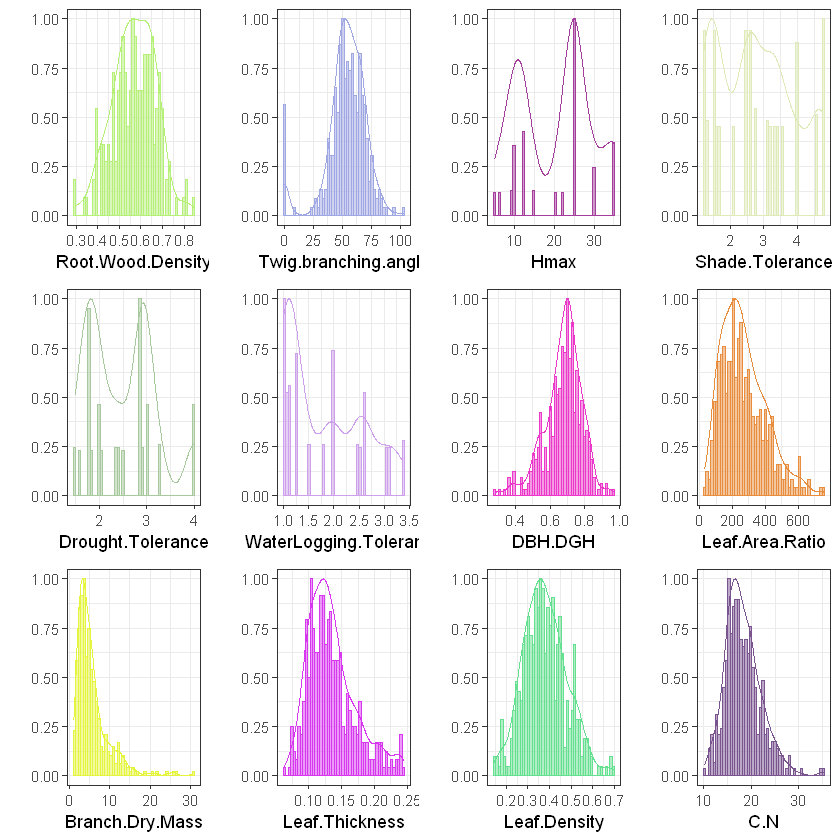

TableGrob (2 x 4) "arrange": 7 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (1-1,3-3) arrange gtable[layout]
4 4 (1-1,4-4) arrange gtable[layout]
5 5 (2-2,1-1) arrange gtable[layout]
6 6 (2-2,2-2) arrange gtable[layout]
7 7 (2-2,3-3) arrange gtable[layout]


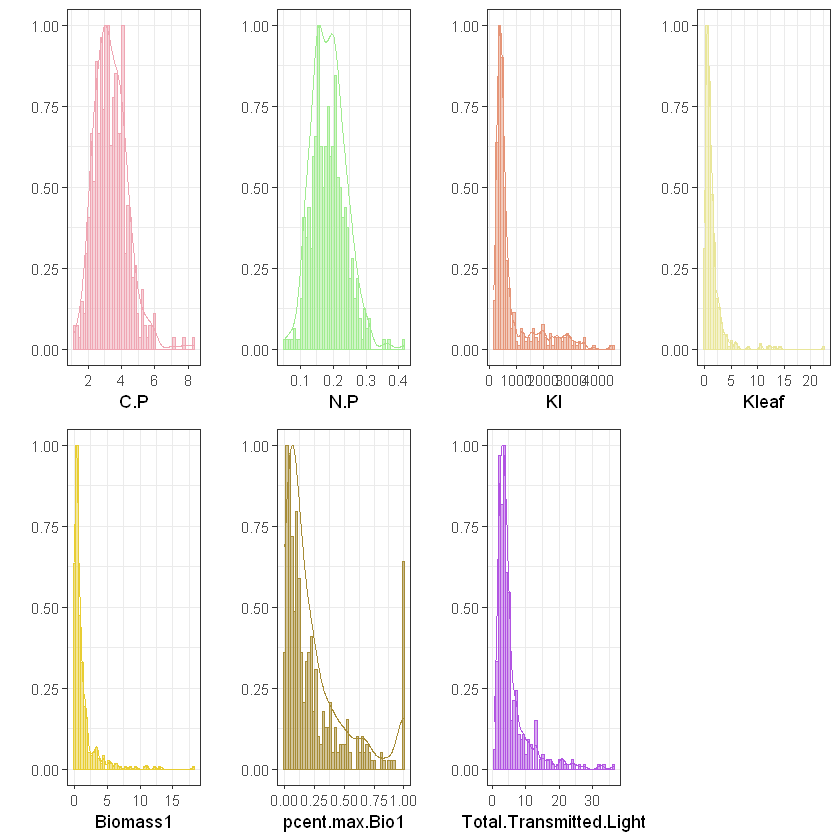

In [13]:
data_distribution(MSH.Raw)

Same as above, the data are non-normal (in some places) and skewed.

After doing some reading, it seems as though the  robust EMbased imputation method (VIM) performs well for imputation. But the data are generally non-normal and this methods uses an OLS. I will still simply use ppm. I read that m = 5 is usually enough.  

# Imputation

In [14]:
library(mice)
library(RVAideMemoire)

Warning message:
"package 'mice' was built under R version 3.6.3"
Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Warning message:
"package 'RVAideMemoire' was built under R version 3.6.3"*** Package RVAideMemoire v 0.9-77 ***


Might be best to just drop some the columns trait values with a large % of missing data. 

For the trait data, I will simply remove those with a majority of missing cases before running the imputation - I am thinking of using a cut of less than 50%. 

In [15]:
# removing cases with a bunch of zeroes
MSH.50 <- MSH.Raw[,names(which(sapply(colnames(MSH.Raw), function (x) {sum(is.na(MSH.Raw[,x]))/nrow(MSH.Raw)<0.5})))]

In [16]:
# I only want columns that are numeric
numeric_columns_msh <- suppressWarnings(which(apply(MSH.50,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE)))))
numeric_columns_rgr <- suppressWarnings(which(apply(RGR.Raw,2, function (x) !is.na(mean(as.numeric(x), na.rm = TRUE)))))

In [17]:
# I read somewhere that p>5 does not change the overall values sigicantly. So, I will stick to that number of datasets.
MSH.IP.MICE <- mice(data.matrix(MSH.50[,numeric_columns_msh]), 
               printFlag = FALSE, method = "pmm", m = 5, seed = 300)

Warning message:
"Number of logged events: 700"

Now, I will run the imputation on these data. Since I have removed the columns with a large amount of missing cases, the imputation should work. If not, I will set a more stringent condition. 

In [18]:
# fit a lm and see if results are comparable between mice output and raw data
summary(lm(Tree.Height ~ Soil.Depth + Biomass1 + Soil.Humidity + pH, data = MSH.50))


Call:
lm(formula = Tree.Height ~ Soil.Depth + Biomass1 + Soil.Humidity + 
    pH, data = MSH.50)

Residuals:
    Min      1Q  Median      3Q     Max 
-304.41 -101.11  -18.78   91.56  495.91 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   385.9302    60.8228   6.345 9.97e-10 ***
Soil.Depth      0.3963     0.5551   0.714    0.476    
Biomass1       19.4801     4.7410   4.109 5.35e-05 ***
Soil.Humidity  89.0918    54.2310   1.643    0.102    
pH             -0.7311    11.1843  -0.065    0.948    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 132.4 on 257 degrees of freedom
  (133 observations deleted due to missingness)
Multiple R-squared:  0.08433,	Adjusted R-squared:  0.07008 
F-statistic: 5.917 on 4 and 257 DF,  p-value: 0.0001435


In [19]:
# need to add descriptive classes
MSH_class_factor <- which(sapply(1:ncol(MSH.Raw), function (x) is.factor(class(MSH.Raw[,x]))))

In [20]:
library(sjmisc)
# Trying again, but this time I will use the above package to combine the imputed datasets to one dataset
MSH.IP <- merge_imputations(MSH.Raw, MSH.IP.MICE, ori = cbind(MSH.Raw[, MSH_class_factor],MSH.50))
summary(lm(Tree.Height ~ Soil.Depth + Biomass1 + Soil.Humidity_imp + pH_imp, data = MSH.IP))

Warning message:
"package 'sjmisc' was built under R version 3.6.3"
Attaching package: 'sjmisc'

The following object is masked from 'package:tidyr':

    replace_na




Call:
lm(formula = Tree.Height ~ Soil.Depth + Biomass1 + Soil.Humidity_imp + 
    pH_imp, data = MSH.IP)

Residuals:
    Min      1Q  Median      3Q     Max 
-317.26  -99.20  -18.44   93.97  496.64 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       417.2654    26.2307  15.908  < 2e-16 ***
Soil.Depth          0.4301     0.5047   0.852   0.3948    
Biomass1           20.3837     4.4413   4.590 6.54e-06 ***
Soil.Humidity_imp  85.0610    49.9737   1.702   0.0898 .  
pH_imp             -6.7089     3.1158  -2.153   0.0321 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 129.7 on 300 degrees of freedom
  (90 observations deleted due to missingness)
Multiple R-squared:  0.1006,	Adjusted R-squared:  0.0886 
F-statistic: 8.388 on 4 and 300 DF,  p-value: 1.995e-06


The regression coefficients do vary slightly. But the direction and significance of these relationships are near the same.

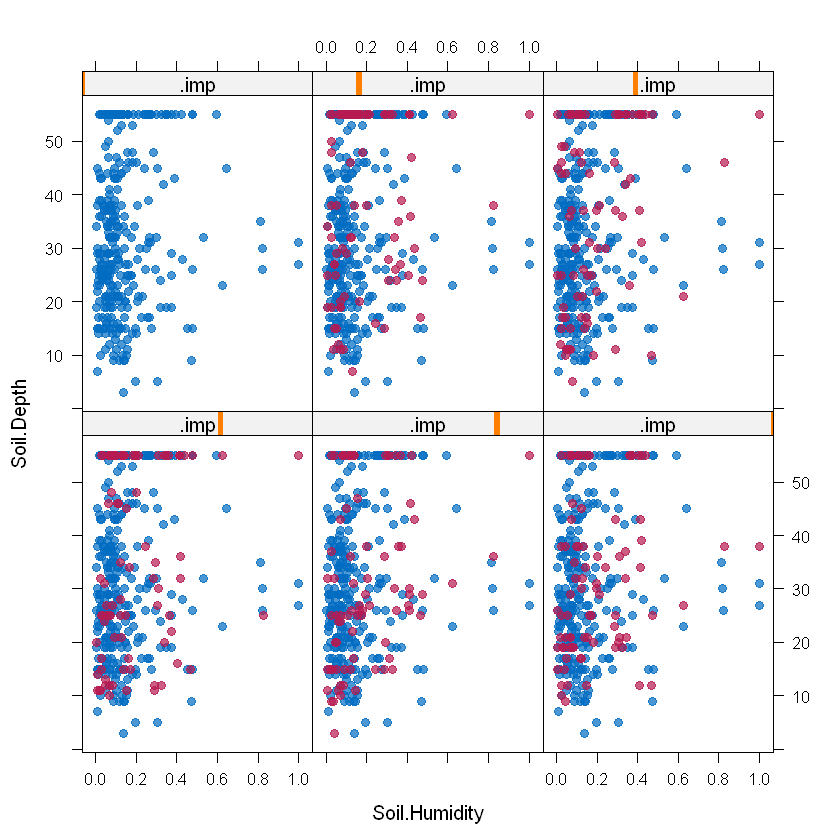

In [21]:
# how do the combined and imputed datasets compare?
xyplot(MSH.IP.MICE, Soil.Depth ~ Soil.Humidity|.imp, pch = 20, cex = 1.4)

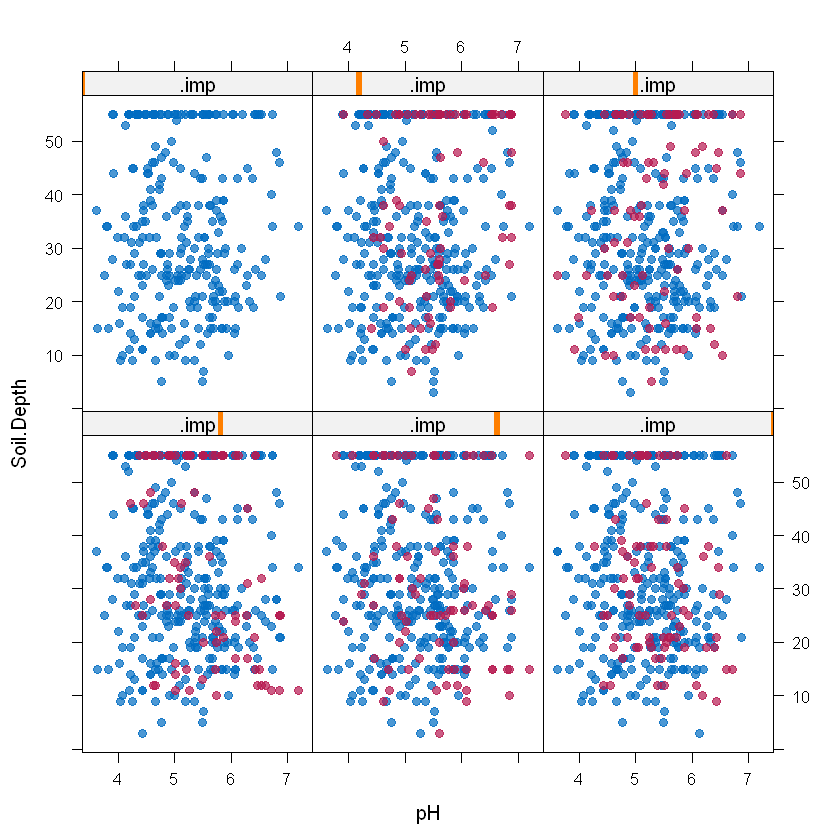

In [22]:
xyplot(MSH.IP.MICE, Soil.Depth ~ pH|.imp, pch = 20, cex = 1.4)

The imputed data seems to match that of the raw data.  Now, how do the combined imputed data compare to the 5 datatsets from the imputation. 

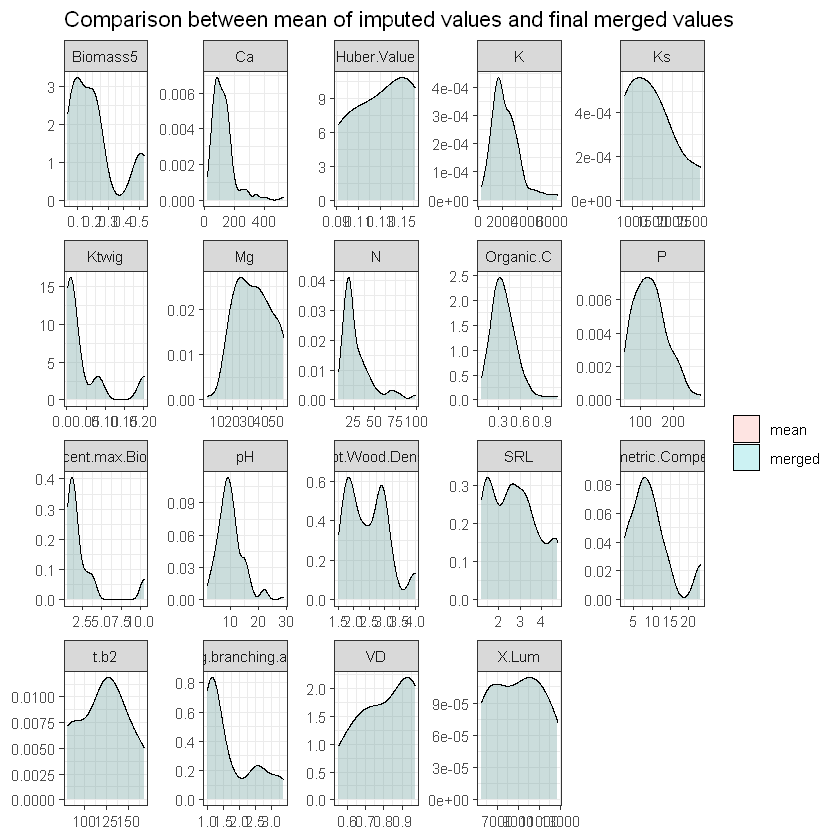

In [23]:
merge_imputations(MSH.Raw, MSH.IP.MICE, summary =  "dens")

There is strong overlap between the mean and merged values. As such, I can be confident that the merged data set is representative of individual imputations. 

# Estimate Growth Rate

There are three metrics we can use to measure growth rates. They are:
* Basal Area Increment
* Biomass Increment
* Biomass Scaled to Height: The issue here is that we do not have height in 2006, so we will just presume that height changed linearly.

In [26]:
RGR_MSH <- merge(RGR.Raw,MSH.IP, by = "SampleID" )

In [27]:
RGR_MSH$BAI_GR <- with(data = RGR_MSH, exp = ((BA.0.2011 - BA.0.2006)/5))
RGR_MSH$BIOI_GR <- with(data = RGR_MSH, exp = (BAI_GR * Root.Wood.Density_imp))
RGR_MSH$BIOSH_GR <- with(data = RGR_MSH, exp = ((BA.0.2011*Tree.Height- (BA.0.2006*(Tree.Height/Tree.Age)))/5))

ERROR: Error in eval(substitute(expr), data, enclos = parent.frame()): object 'BA_GR' not found


In [ ]:
write.csv(RGR_MSH, "C:/Users/jodyn/OneDrive/Github/Trait-Performance-Relationships/data/RGR_MSH.csv")

# Conclusion

So, we had some missing data in the trait dataset, which were imputed using predictive mean matching. I see that the data, on average, is skewed and non-normal. As such, using a machine learning method to elucidate which variables are useful is a good step because we do not have to worry about the data being non-normal or non-linear. I will use random forest to build this model. 